----
# SMILES-GPT: Generative Pre-Training from Molecules

In this notebook, we demonstrate how to pretrain
[HuggingFace](https://huggingface.co/transformers/)
[GPT-2](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2lmheadmodel) language model 
on a SMILES corpus.

The pretrained model can be used for transferring knowledge to downstream tasks
including molecular property prediction. Check out
[`smiles_gpt`](https://github.com/sanjaradylov/smiles-gpt/tree/master/smiles_gpt)
repository and/or:
> Adilov, Sanjar (2021): Generative Pre-Training from Molecules. ChemRxiv. Preprint. https://doi.org/10.33774/chemrxiv-2021-5fwjd

---
## Install Dependencies

### a) Install packages

This will take a while. Tested on a Python 3.10 kernel.

In [2]:
!pip install pandas
!pip install rdkit
!pip install torch
!pip install torchvision
!pip install torchaudio
!pip install plotly
!pip install optuna
!pip install scikit-learn
!pip install tokenizers
!pip install pytorch-lightning
!pip install bertviz
!pip install selfies

Looking in indexes: https://pypi.python.org/simple/
Looking in indexes: https://pypi.python.org/simple/
Looking in indexes: https://pypi.python.org/simple/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 3.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 7.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 36.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 41.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 8.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 18.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### b) Main package

Our [`smiles_gpt`](https://github.com/sanjaradylov/smiles-gpt/tree/master/smiles_gpt)
package implements
[pytorch-lightning](https://www.pytorchlightning.ai/)-compatible modules for data loading,
model training and testing. The SMILES tokenizer and downstream regression and
single-/multi-output classification models are also compatible with HuggingFace API.

In [97]:
# Lead repo into to Python path
import sys
sys.path.insert(0,'../tools/smiles-gpt-github')

Install widget extension for Jupyter:

In [5]:
!jupyter nbextension enable --py widgetsnbextension
from tqdm import tqdm_notebook, tqdm

Config option `kernel_spec_manager_class` not recognized by `EnableNBExtensionApp`.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Import SMILES-GPT.

In [24]:
import smiles_gpt as gpt

--------------
## GPT-2 Model

Now we load HuggingFace
[`GPT2LMHeadModel`](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2lmheadmodel)
with the configuration composed of previously
defined model hyperparameters. The model processes mini-batch of input ids and labels, then
returns predictions and cross-entropy loss between labels and predictions.

GPT-2 is trained with autoregressive language modeling objective:
$$
P(\boldsymbol{s}) = P(s_1) \cdot P(s_2 | s_1) \cdots P(s_T | s_1, \ldots, s_{T-1}) =
\prod_{t=1}^{T} P(s_t | s_{j < t}),
$$
where $\boldsymbol{s}$ is a tokenized (encoded) SMILES string, $s_t$ is a token from pretrained 
vocabulary $\mathcal{V}$.

In [90]:
# Directory of tokenizer and model.
checkpoint = "../models/benchmark-10m"
tokenizer_filename = f"{checkpoint}/tokenizer.json"

In [91]:
import os
os.listdir(checkpoint)

['pytorch_model.bin',
 'config.json',
 'merges.txt',
 'tokenizer.json',
 'vocab.json']

### a) Tokenization

`smiles_gpt.SMILESBPETokenizer` first splits SMILES strings into characters, runs
byte-pair encoding, and augments the resulting list with `"<s>"` (beginning-of-SMILES) and
`"</s>"` (end-of-SMILES) special tokens. `smiles_gpt.SMILESAlphabet` stores 72 possible
characters as an initial vocabulary.

[`SMILESBPETokenizer`](https://github.com/sanjaradylov/smiles-gpt/blob/master/smiles_gpt/tokenization.py#L23)
inherits `BaseTokenizer` from
[Tokenizers](https://huggingface.co/docs/tokenizers/python/latest/index.html). It is already
useful by itself, however, to make it more convenient and follow HuggingFace API, we load
`transformers.PreTrainedTokenizerFast` instance of our tokenizer.

In [92]:
from pprint import pprint
tokenizer = gpt.SMILESBPETokenizer.get_hf_tokenizer(
    tokenizer_filename, model_max_length=hyperparams["max_length"])
smiles_string = "CC(Cl)=CCCC=C(C)Cl"
smiles_encoded = tokenizer(smiles_string)
smiles_merges = tokenizer.convert_ids_to_tokens(smiles_encoded["input_ids"])
pprint(smiles_encoded)
pprint(smiles_merges)

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [1, 78, 142, 24, 101, 218, 109, 63, 2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
['<s>', 'CC', '(Cl)', '=', 'CCCC', '=C', '(C)C', 'l', '</s>']


### b) Interpretability

[BertViz](https://github.com/jessevig/bertviz) inspects attention heads of transformers
capturing specific patterns in data. Each head can be representative of some syntactic
or short-/long-term relationships between tokens.

In [94]:
import torch
from transformers import GPT2Config, GPT2LMHeadModel

smiles = "CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1"
inputs = tokenizer(smiles, add_special_tokens=False, return_tensors="pt")
input_ids_list = inputs["input_ids"].tolist()[0]
model = GPT2LMHeadModel.from_pretrained(f"{checkpoint}/", output_attentions=True)
attention = model(torch.LongTensor(input_ids_list))[-1]
tokens = tokenizer.convert_ids_to_tokens(input_ids_list)

In [32]:
tokens

['CC[NH+](CC)', 'C1', 'CCC(', '[NH2+]', 'C2CC2)', '(C(=O)[O-])', 'C1']

In [33]:
from bertviz import head_view

# Don't worry if a snippet is not displayed---just rerun this cell.
head_view(attention, tokens)

<IPython.core.display.Javascript object>

In [96]:
from bertviz import model_view

# Don't worry if a snippet is not displayed---just rerun this cell.
model_view(attention, tokens, include_layers=[5], display_mode='light')

<IPython.core.display.Javascript object>

### c) Sampling

Finally, we generate novel SMILES strings with top-$p$ sampling$-$i.e., sampling from the
smallest vocabulary subset $\mathcal{V}^{(p)} \subseteq \mathcal{V}$ s.t. it takes up the most
probable tokens whose cumulative probability mass exceeds $p$, $0 < p < 1$. Model
terminates the procedure upon encountering `"</s>"` or reaching maximum number
`hyperparams["max_length"]`. Special tokens are eventually removed.

In [95]:
import tqdm
model.eval()  # Set the base model to evaluation mode.
generated_smiles_list = []
n_generated = 100
for _ in tqdm.tqdm(range(n_generated)):
    # Generate from "<s>" so that the next token is arbitrary.
    smiles_start = torch.LongTensor([[tokenizer.bos_token_id]])
    # Get generated token IDs.
    generated_ids = model.generate(smiles_start,
                                   max_length=hyperparams["max_length"],
                                   do_sample=True, top_p=hyperparams["top_p"],
                                   pad_token_id=tokenizer.eos_token_id)
    # Decode the IDs into tokens and remove "<s>" and "</s>".
    generated_smiles = tokenizer.decode(generated_ids[0],
                                        skip_special_tokens=True)
    generated_smiles_list.append(generated_smiles)
generated_smiles_list[:10]

100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


['C[NH2+]C(Cc1ccc(Br)cn1)c1cc(Cl)ccc1F',
 'Cc1cc(NC(=O)c2ccc(C(F)(F)F)cc2)nn1C',
 'Cc1cc(F)ccc1C(O)Cc1cccs1',
 'CC(=O)OCC1OC(n2cnc3c(=O)nc[nH]c32)C(OC(C)=O)C1OC(C)=O',
 'COc1cc(C(=O)OCC(NC(=O)C2CCCCC2)C(O)CC(Cc2ccccc2)NC(=O)OC(C)(C)C)cc(OC)c1OC',
 'O=C1NC(=S)NC1=Cc1cc(I)c(OCc2ccccc2F)c(I)c1',
 'CCOCCCN(CC(=O)N(Cc1cccn1Cc1ccc(F)cc1)C1CCCCC1)C(=O)c1cc(OC)cc(OC)c1',
 'CC(C)c1ccc(C(C(=O)NC2CCCCC2)N(C(=O)CNC(=O)c2ccco2)c2ccc3c(c2)OCO3)cc1',
 'CCOC(=O)c1c(NC(=O)Cc2ccc(OCc3ccccc3)cc2)scc1c1ccc(OCC)cc1',
 'COc1nc(N)nc2c1ncn2C1OC(COP(=O)(OCC2OC(n3cnc4c(=O)nc(N)[nH]c43)C3OC(C)(C)OC23)SC(=O)c2ccccc2Cl)C(O)C1(C)O']

In [67]:
from rdkit.Chem import MolFromSmiles
from rdkit.RDLogger import DisableLog
from rdkit.Chem.Draw import MolsToGridImage
DisableLog("rdApp.*")

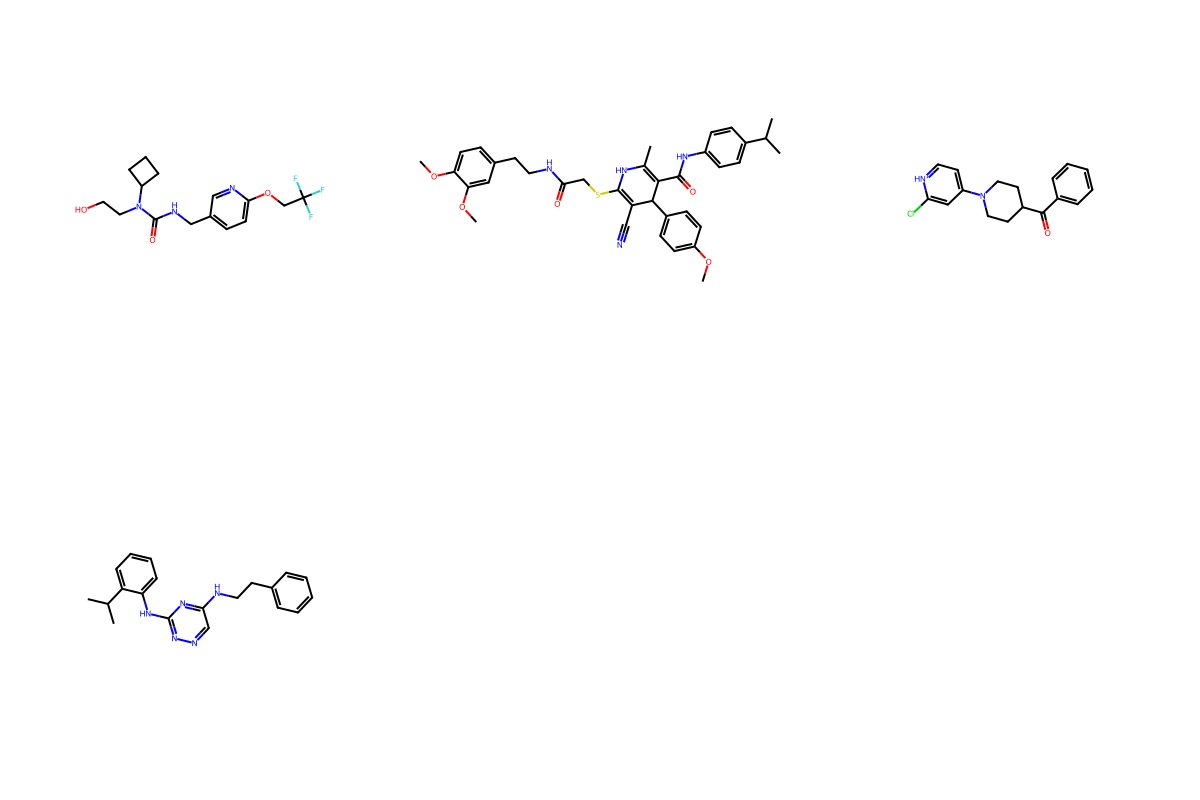

In [84]:
valid_molecules = []
for smiles in generated_smiles_list:
    molecule = MolFromSmiles(smiles)
    if molecule is not None:
        valid_molecules.append(molecule)
MolsToGridImage(valid_molecules[:4],subImgSize=(400, 400))

### d) Generation examples from SMILES

Here we try to auto-complete / generate SMILES strings

In [85]:
import tqdm
model.eval()  # Set the base model to evaluation mode.
smiles = "OCc1ccc"
prompt = tokenizer(smiles, add_special_tokens=False, return_tensors="pt")
input_ids_list = prompt["input_ids"].tolist()
print(smiles)
print(tokenizer.convert_ids_to_tokens(input_ids_list[0]))
n_generated = 10

OCc1ccc
['OC', 'c1ccc']


In [86]:
generated_smiles_list_1 = []
for _ in tqdm.tqdm(range(n_generated)):
    smiles_start = torch.LongTensor(input_ids_list)
    # Get generated token IDs.
    generated_ids = model.generate(smiles_start,
                                   max_length=50,
                                   num_beams=5,
                                   num_return_sequences=5,
                                   no_repeat_ngram_size=2,
                                   #early_stopping=True,
                                   pad_token_id=tokenizer.eos_token_id
                                  )
    # Decode the IDs into tokens and remove "<s>" and "</s>".
    for i, beam in enumerate(generated_ids):
        generated_smiles = tokenizer.decode(beam, skip_special_tokens=True)
        generated_smiles_list_1.append(generated_smiles)

100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


In [73]:
generated_smiles_list_2 = []
for _ in tqdm.tqdm(range(n_generated)):
    smiles_start = torch.LongTensor(input_ids_list)
    # Get generated token IDs.
    generated_ids = model.generate(smiles_start,
                            max_length= 50,  
                            do_sample=True,  
                            top_k=100,
                            top_p=0.92,
                            temperature=0.8,
                            repetition_penalty=1.5,
                            num_return_sequences=5,
                            pad_token_id=tokenizer.eos_token_id
                            )
    # Decode the IDs into tokens and remove "<s>" and "</s>".
    for i, beam in enumerate(generated_ids):
        generated_smiles = tokenizer.decode(beam, skip_special_tokens=True)
        generated_smiles_list_2.append(generated_smiles)

100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


In [72]:
generated_smiles_list_3 = []
for _ in tqdm.tqdm(range(n_generated)):
    smiles_start = torch.LongTensor(input_ids_list)
    # Get generated token IDs.
    generated_ids = model.generate(smiles_start,
                                   max_length=50,
                                   do_sample=True, 
                                   top_p=hyperparams["top_p"],
                                   pad_token_id=tokenizer.eos_token_id)
    # Decode the IDs into tokens and remove "<s>" and "</s>".
    for i, beam in enumerate(generated_ids):
        generated_smiles = tokenizer.decode(beam, skip_special_tokens=True)
        generated_smiles_list_3.append(generated_smiles)

100%|██████████| 10/10 [00:01<00:00,  5.46it/s]


In [81]:
print(len(generated_smiles_list_1))
print(len(generated_smiles_list_2))
print(len(generated_smiles_list_3))

50
50
10


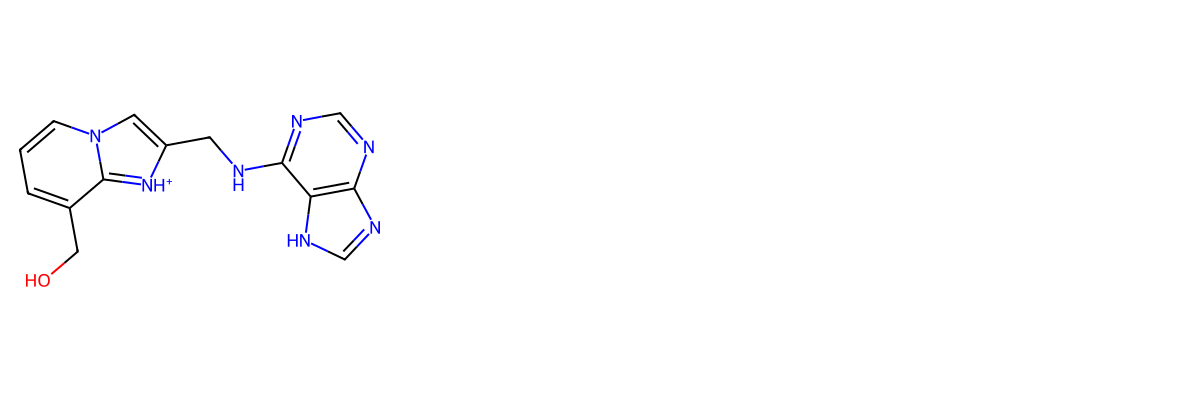

In [74]:
MolsToGridImage([MolFromSmiles(generated_smiles_list_1[0])], subImgSize=(400, 400))

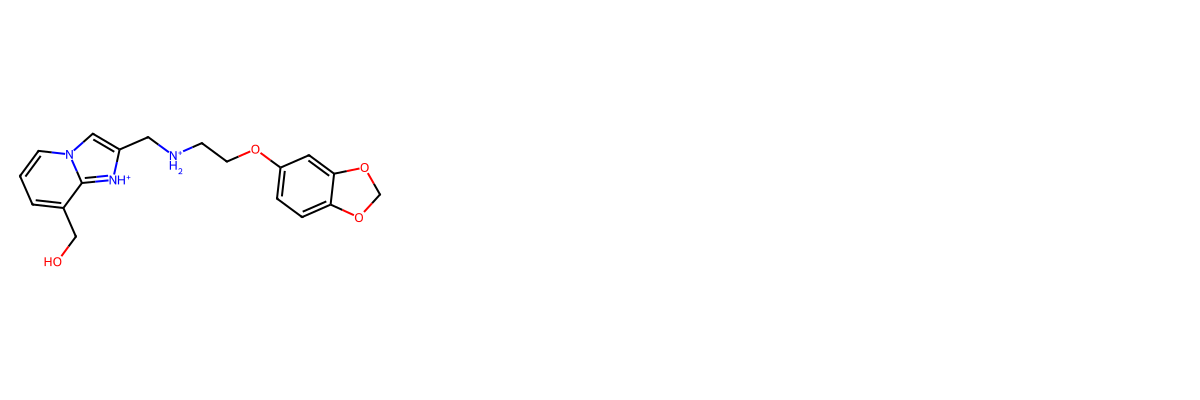

In [75]:
MolsToGridImage([MolFromSmiles(generated_smiles_list_2[21])], subImgSize=(400, 400))

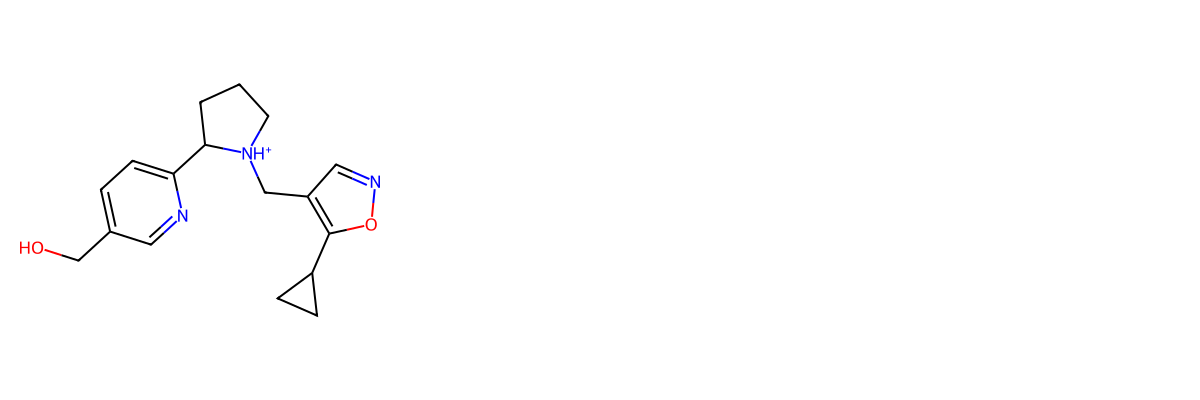

In [79]:
MolsToGridImage([MolFromSmiles(generated_smiles_list_3[7])], subImgSize=(400, 400))